In [3]:
# Import libraries
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import random
import copy

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures


import warnings
warnings.filterwarnings("ignore") # In order not to show the warnings in the notebook


# Introduction
The bitcoin
price prediction that has been worked on in this project is a
regression problem, where the prediction model predicts the
next Bitcoin price based on the previous. We studied, implemented and compared various Machine Learning and deep
learning methods, such as, prophet, Convolutional Neural
Network (CNN) and long short-term memory (LSTM).

## Data Used

The dataset in the project is imported by Python using
Yahoo APIs and contains the USD bitcoin price of each day
from 2014 to 2021 and it includes six features: Open indicates the price at the beginning of the day, Close indicates
the price at the end of the day, Adjusted Close, Volume of
the sale, High price of the day and Low price of the day.

## Data Preprocessing

### Importing and Analysing the Data

In [4]:
# Importing data 
Bitcoin_data = pd.read_csv('data.csv', parse_dates=['Date'], sep=',', index_col='Date')
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
Bitcoin_data.head(5)

,Open,High,Low,Adj Close,Volume,Close
Date,,,,,,
2014-09-16,465.864014,468.174011,452.421997,457.334015,21056800.0,457.334015
2014-09-17,456.859985,456.859985,413.104004,424.440002,34483200.0,424.440002
2014-09-18,424.102997,427.834992,384.532013,394.795990,37919700.0,394.795990
2014-09-19,394.673004,423.295990,389.882996,408.903992,36863600.0,408.903992
2014-09-20,408.084992,412.425995,393.181000,398.821014,26580100.0,398.821014


In [5]:
# checking for nulls
Bitcoin_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2586 entries, 2014-09-16 to 2021-10-19
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2586 non-null   float64
 1   High       2586 non-null   float64
 2   Low        2586 non-null   float64
 3   Adj Close  2586 non-null   float64
 4   Volume     2586 non-null   float64
 5   Close      2586 non-null   float64
dtypes: float64(6)
memory usage: 141.4 KB


The
dataset has been examined for null values and it didn’t have any missing values.

In [6]:
# checking if close is not equal to adj close
Bitcoin_data[Bitcoin_data['Close']!=Bitcoin_data['Adj Close']]

,Open,High,Low,Adj Close,Volume,Close
Date,,,,,,


The ‘Close’ and ‘Adj Close’
columns are identical because Cryptocurrency prices differ
from traditional stock prices. So ‘Close’ price is chosen as
the target variable.

In [7]:
# checking the main parameters
Bitcoin_data.describe()

,Open,High,Low,Adj Close,Volume,Close
count,2586.000000,2586.000000,2586.000000,2586.000000,2.586000e+03,2586.000000
mean,9460.479761,9729.703537,9173.223236,9483.798763,1.375499e+10,9483.798763
std,13881.464139,14299.916556,13424.115329,13919.027751,1.989196e+10,13919.027751
min,176.897003,211.731003,171.509995,178.102997,5.914570e+06,178.102997
25%,577.754990,582.823242,573.438751,577.567490,7.406615e+07,577.567490
50%,5515.076172,5647.827149,5353.012940,5540.485108,4.568140e+09,5540.485108
75%,9699.704834,9908.871582,9507.834717,9700.673340,2.224211e+10,9700.673340
max,63523.753910,64863.097660,62208.964840,63503.457030,3.510000e+11,63503.457030


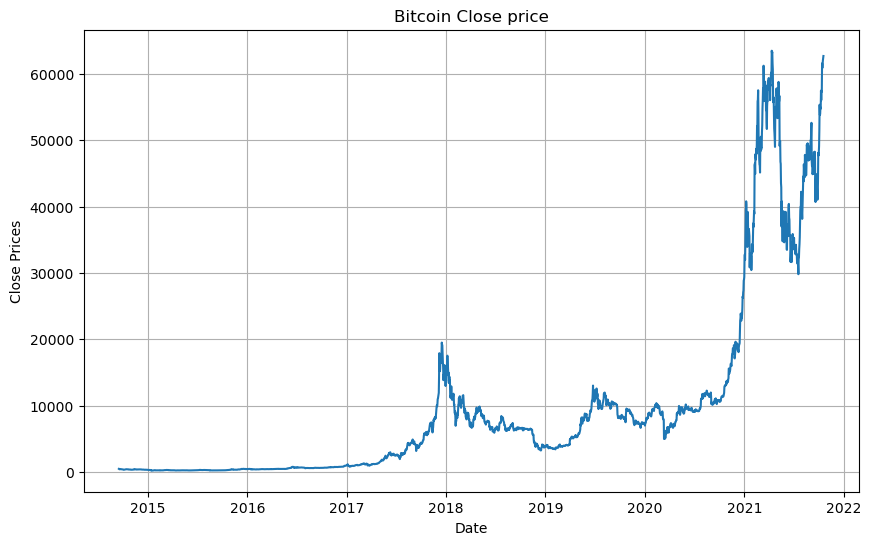

In [8]:
# Plot closing prices
df_close = Bitcoin_data['Close']

plt.figure(figsize=(10,6))
plt.grid()
plt.plot(df_close)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.title('Bitcoin Close price');

# Regression

In [9]:
# Assuming Bitcoin_data is a pandas DataFrame with 'Close' and 'Volume' columns
# reg_data is a deep copy of Bitcoin_data to ensure we don't alter the original data
reg_data = copy.deepcopy(Bitcoin_data)

# Feature Engineering
# S_3 is the moving average of 3 previous days, and S_9 is the moving average of 9 previous days
reg_data['S_3'] = reg_data['Close'].shift(1).rolling(window=3).mean() 
reg_data['S_9'] = reg_data['Close'].shift(1).rolling(window=9).mean() 

# Define X_i as the ith previous close price (lag features)
for i in range(1, 11):
    reg_data[f"X_{i}"] = reg_data['Close'].shift(i)

# Define R_i as the ith previous return (Return(t) = P(t) / P(t-1))
for i in range(1, 11):
    reg_data[f"R_{i}"] = reg_data['Close'].shift(i) / reg_data['Close'].shift(i+1)

# Define V_i as the ith previous volume
for i in range(1, 11):
    reg_data[f"V_{i}"] = reg_data['Volume'].shift(i)

# Drop rows with NaN values resulting from the shift operations
reg_data = reg_data.dropna()

# Define the feature sets for different models
required_features = ['S_3', 'S_9', 'X_1', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7', 'X_8', 'X_9', 'X_10']
required_features_r = ['R_1', 'R_2', 'R_3', 'R_4', 'R_5', 'R_6', 'R_7', 'R_8', 'R_9', 'R_10']

# Define the output labels
output_label = 'Close'
reg_data["r_1"] = reg_data["Close"] / reg_data["X_1"]  # Relative change label
output_label_r = 'r_1'

# Set up train/validation/test split ratios
train_ratio = 0.6  # 60% training data
validation_ratio = 0.2  # 20% validation data
test_ratio = 0.2  # 20% testing data

# Calculate the split indices
train_end = int(train_ratio * len(reg_data))
validation_end = train_end + int(validation_ratio * len(reg_data))

# Helper function to calculate metrics
def calculate_metrics(model, X_val, y_val, model_name):
    y_pred = model.predict(X_val)
    mape = mean_absolute_percentage_error(y_val, y_pred) * 100
    mae = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    
    # Store results in dictionary
    validation_results[model_name] = {'MAPE': mape, 'MAE': mae, 'RMSE': rmse}

    return mape, mae, rmse

# Store validation results
validation_results = {}

# ----------- Linear Model with Absolute Values and Moving Averages -----------

X = reg_data[required_features]
y = reg_data[output_label]

# Split the data into train, validation, and test
X_train = X[:train_end]
y_train = y[:train_end]
X_validation = X[train_end:validation_end]
y_validation = y[train_end:validation_end]
X_test = X[validation_end:]
y_test = y[validation_end:]

# Train Linear Regression model
lin_model = LinearRegression().fit(X_train, y_train)

# Calculate validation metrics
mape_lin, mae_lin, rmse_lin = calculate_metrics(lin_model, X_validation, y_validation, "Linear Model")

# ----------- Polynomial Model -----------
polynomial_features = PolynomialFeatures(degree=2)
X_poly = polynomial_features.fit_transform(X)

# Split polynomial transformed data
X_train_poly = X_poly[:train_end]
X_validation_poly = X_poly[train_end:validation_end]
X_test_poly = X_poly[validation_end:]

# Train Polynomial model
poly_model = LinearRegression().fit(X_train_poly, y_train)

# Calculate validation metrics
mape_poly, mae_poly, rmse_poly = calculate_metrics(poly_model, X_validation_poly, y_validation, "Polynomial Model")

# ----------- Linear Model with Relative Values -----------
X_r = reg_data[required_features_r]
y_r = reg_data[output_label_r]

# Split data into train/validation/test
X_train_r = X_r[:train_end]
y_train_r = y_r[:train_end]
X_validation_r = X_r[train_end:validation_end]
y_validation_r = y_r[train_end:validation_end]
X_test_r = X_r[validation_end:]
y_test_r = y_r[validation_end:]

# Train Relative Linear Regression model
rel_model = LinearRegression().fit(X_train_r, y_train_r)

# Calculate validation metrics
mape_rel, mae_rel, rmse_rel = calculate_metrics(rel_model, X_validation_r, y_validation_r, "Relative Model")


# ----------- Compare Validation Results -----------

# Select the model with the lowest RMSE on the validation set
best_model_name = min(validation_results, key=lambda x: validation_results[x]['RMSE'])
best_model_info = validation_results[best_model_name]

print(f"Best model: {best_model_name}")
print(f"Validation RMSE: {best_model_info['RMSE']}, MAE: {best_model_info['MAE']}, MAPE: {best_model_info['MAPE']}")

# ----------- Apply Best Model to Test Data -----------
if best_model_name == "Linear Model":
    best_model = lin_model
    y_pred_test = best_model.predict(X_test)
elif best_model_name == "Polynomial Model":
    best_model = poly_model
    y_pred_test = best_model.predict(X_test_poly)
elif best_model_name == "Relative Model":
    best_model = rel_model
    y_pred_test = np.multiply(best_model.predict(X_test_r), X_test['X_1'])  # Converting back from relative change

# Calculate final performance on test data
test_mape = mean_absolute_percentage_error(y_test, y_pred_test) * 100
test_mae = mean_absolute_error(y_test, y_pred_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print("\nFinal Test Performance:")
print(f"Test MAPE: {test_mape}%")
print(f"Test MAE: {test_mae}")
print(f"Test RMSE: {test_rmse}")


Best model: Relative Model
Validation RMSE: 0.040611453086811446, MAE: 0.025508574321411164, MAPE: 2.575734468876671

Final Test Performance:
Test MAPE: 2.707284211211468%
Test MAE: 936.5780155135187
Test RMSE: 1490.2116374806283
